In [1]:
try:
    # try if in colab
    import google.colab

    from scripts.colab import setup_colab

    setup_colab()
except ImportError:
    pass

import chromhandler as ch

## Calibration

In [2]:
# path to adenosine calibration data
adenosine_path = "data/hplc/calibration/adenosine"

# parameters
ph = 7.4
temp = 37
temp_unit = "deg_C"

# initialize handler
handler = ch.Handler.read_asm(
    path=adenosine_path,
    ph=ph,
    temperature=temp,
    temperature_unit=temp_unit,
    mode="calibration",
)

# show state of handler
handler

Loaded 6 chromatograms.



╭─ 📋 Handler Overview ───────────────────────────────────────────────────────────────────────────────────────────╮
│ ID: adenosine                                                                                                   │
│ Name: Chromatographic measurement                                                                               │
│ Mode: calibration                                                                                               │
│ Measurements: 6                                                                                                 │
│ Peak Assignment: 0/11 (0.0%)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

 📊 Component Statistics  
┏━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Component      ┃ Count ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Molecules      │     0 │
│ Proteins       │     0 │
│ Measurements   │     6 │

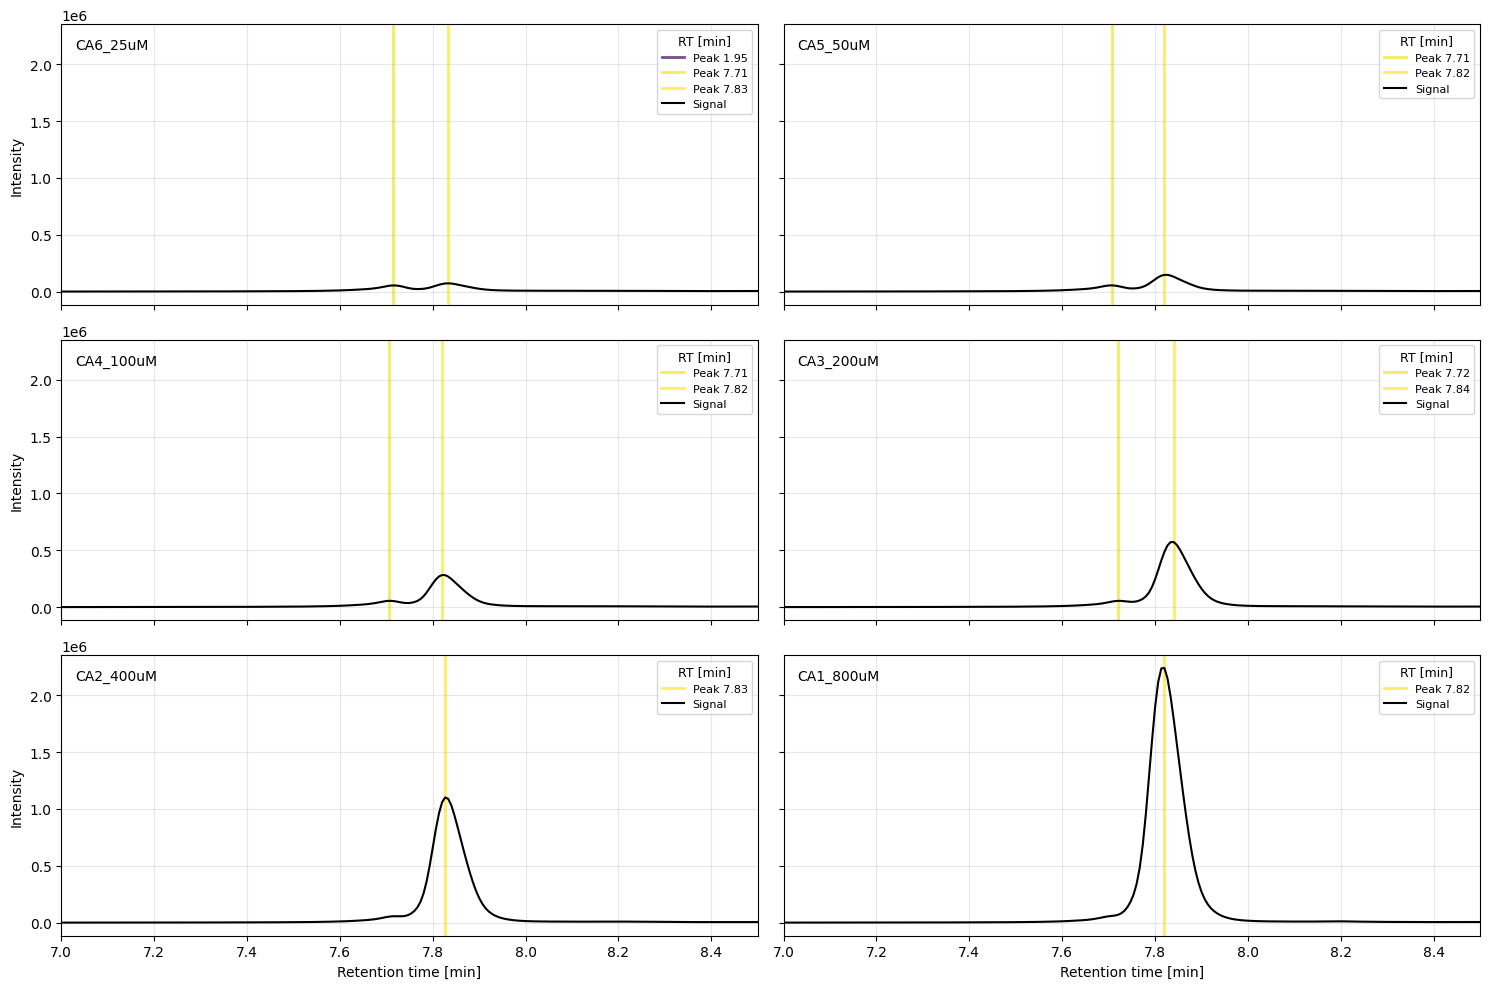

In [3]:
# visualize all chromatograms and peaks
handler.visualize(rt_min=7, rt_max=8.5)

           🎯 Peak Assignment Summary of adenosine           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Molecule              ┃   Status   ┃ Details              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ adenosine (adenosine) │ ✅ Success │ (6/6) peaks assigned │
└───────────────────────┴────────────┴──────────────────────┘

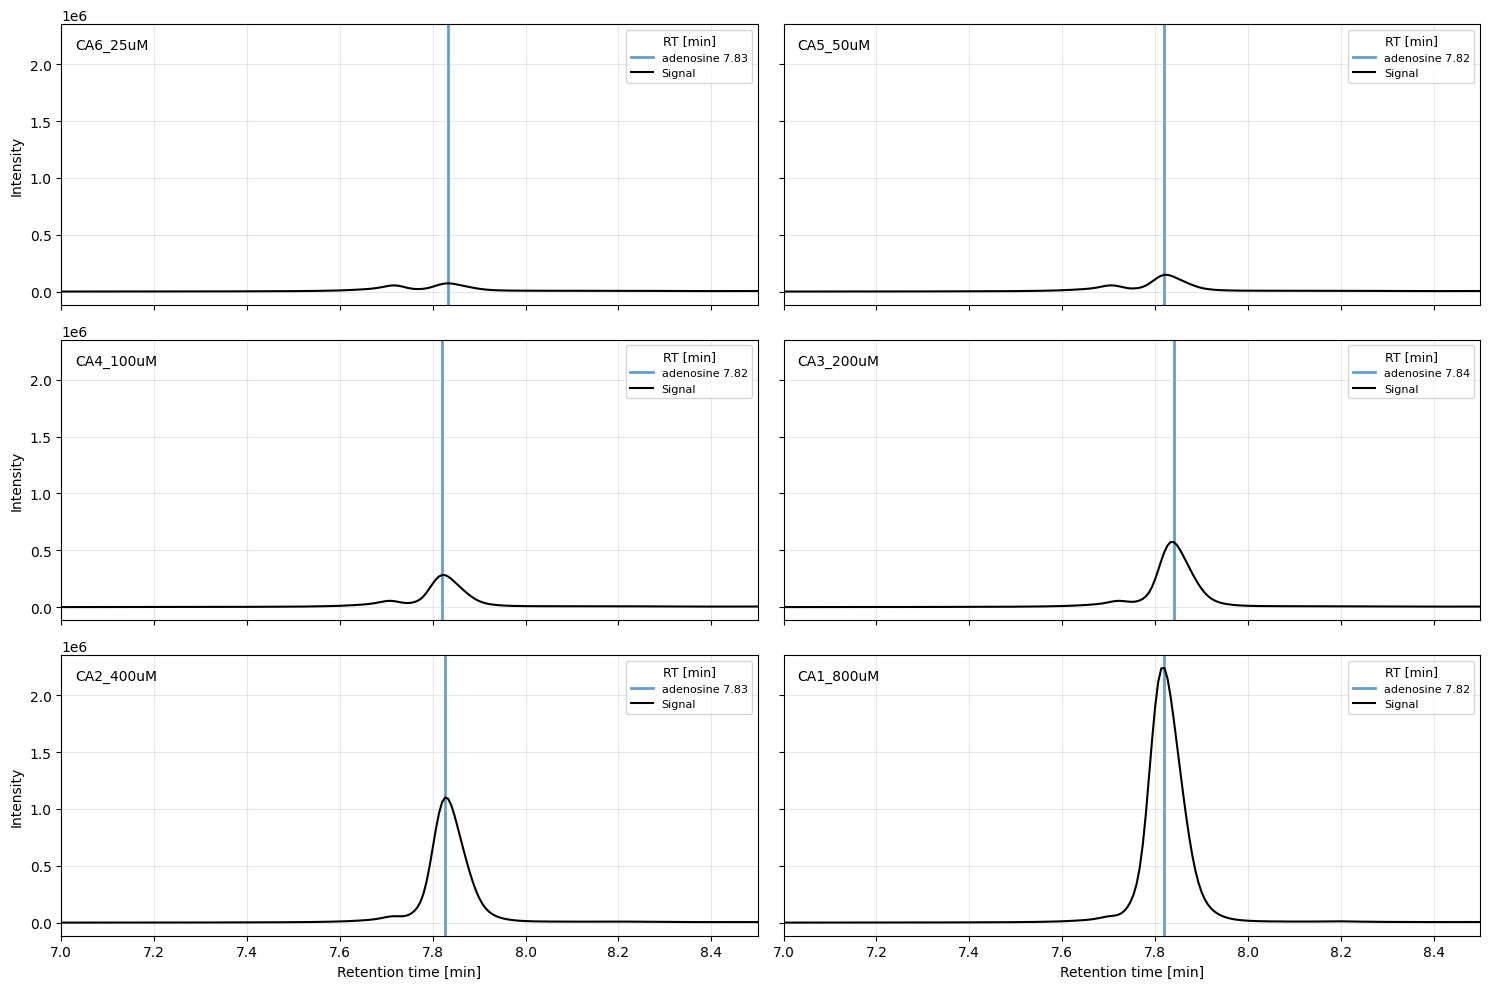

In [4]:
# define adenosine with retention time
adenosine = ch.Molecule(
    id="adenosine",
    name="adenosine",
    pubchem_cid=123456,
    retention_time=7.82,
    retention_tolerance=0.05,
)

# add molecule to handler
handler.add_molecule(adenosine)

# assign molecules to peaks
handler.assign_all_peaks()

# verify assignment
handler.visualize(rt_min=7, rt_max=8.5, assigned_only=True)

✅ Models have been successfully fitted.


                                           Model Overview                                            
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD          ┃ Equation      ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 198 │ 1.0       │ 12256879.6314 │ adenosine * a │ a: 0.2%,                           │
└────────────┴─────┴───────────┴───────────────┴───────────────┴────────────────────────────────────┘

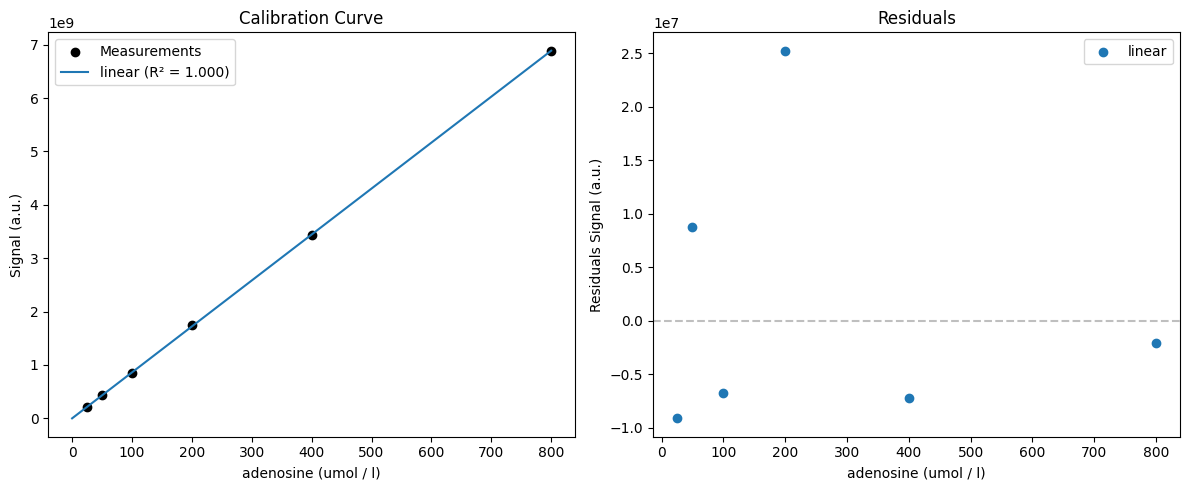

In [5]:
# create standard curve for adenosine
handler.add_standard(molecule=adenosine)

In [6]:
# save molecule to file
adenosine.save_json("data/molecules/adenosine.json")

## 🧪 Now you: repeat the same steps for adenine

In [7]:
adenine_path = "data/hplc/calibration/adenine"

# ...

Loaded 6 chromatograms.


/var/folders/qj/km84d2qd1c7dcj181088k7lh0000gn/T/ipykernel_24031/702948569.py:2: DeprecationWarning: ChromAnalyzer is deprecated and will be removed in version 1.0.0. Use 'Handler' instead.
  handler = ch.ChromAnalyzer.read_asm(


           🎯 Peak Assignment Summary of adenine            
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Molecule             ┃   Status   ┃ Details              ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ adenine (adenine)    │ ✅ Success │ (6/6) peaks assigned │
└──────────────────────┴────────────┴──────────────────────┘

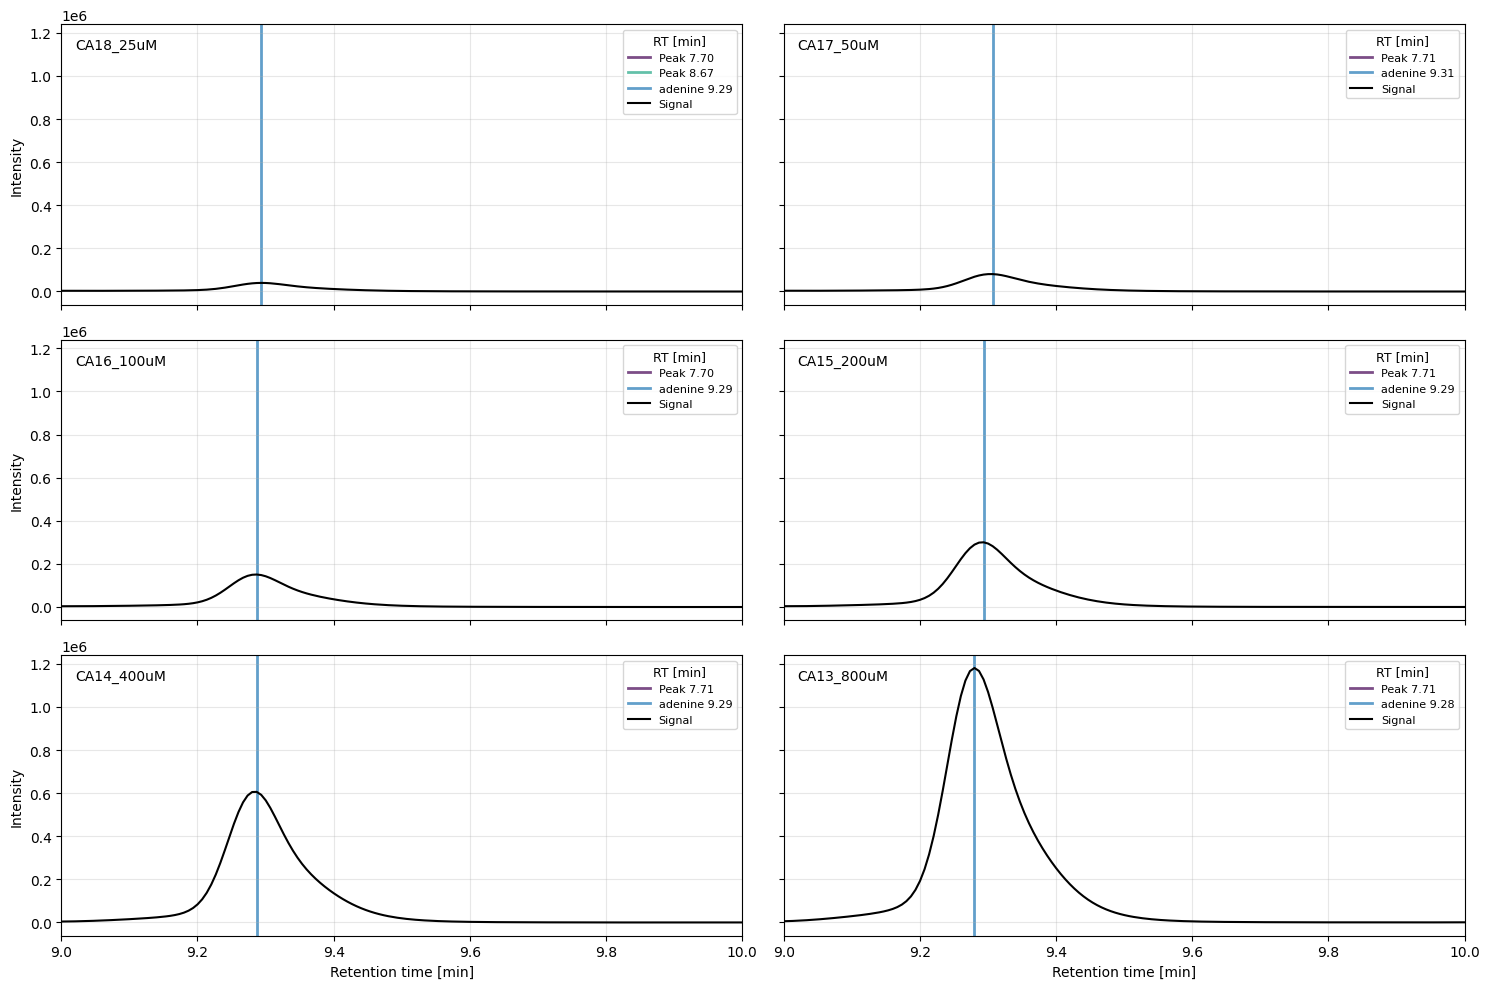

✅ Models have been successfully fitted.


                                          Model Overview                                           
┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC ┃ R squared ┃ RMSD          ┃ Equation    ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ 209 │ 0.9997    │ 32140534.9145 │ adenine * a │ a: 0.5%,                           │
└────────────┴─────┴───────────┴───────────────┴─────────────┴────────────────────────────────────┘

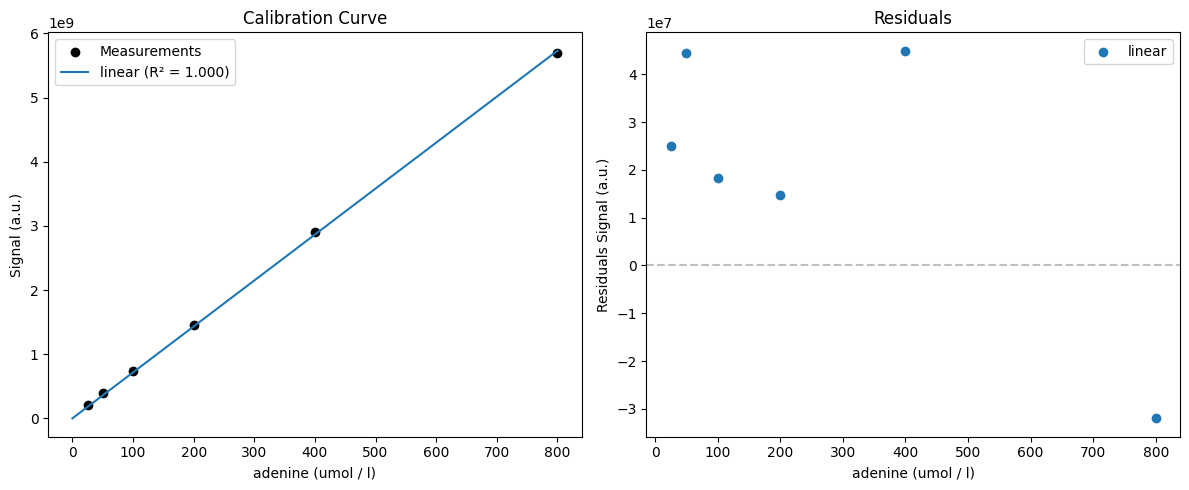

In [8]:
# start handler
handler = ch.ChromAnalyzer.read_asm(
    path=adenine_path,
    ph=ph,
    temperature=temp,
    temperature_unit=temp_unit,
    mode="calibration",
)


# define adenine with retention time
adenine = ch.Molecule(
    id="adenine",
    name="adenine",
    pubchem_cid=123456,
    retention_time=9.29,
)

handler.add_molecule(adenine)

# assign molecule to peaks
handler.assign_all_peaks()

# verify assignment
handler.visualize(rt_min=9, rt_max=10)
# create standard curve for adenine
handler.add_standard(molecule=adenine)

In [9]:
# save molecule to file
adenine.save_json("data/molecules/adenine.json")

## Enzymes

As Molecules, proteins can also be pre-created for later use.

In [10]:
SAHH = ch.Protein(
    id="Q8NSC4",
    name="SAHH",
    sequence="MDFKVADLSLAEAGRHQIRLAEYEMPGLMQLRKEFADEQPLKGARIAGSIHMTVQTAVLIETLTALGAEVRWASCNIFSTQDEAAAAIVVGSGTVEEPAGVPVFAWKGESLEEYWWCINQIFSWGDELPNMILDDGGDATMAVIRGREYEQAGLVPPAEANDSDEYIAFLGMLREVLAAEPGKWGKIAEAVKGVTEETTTGVHRLYHFAEEGVLPFPAMNVNDAVTKSKFDNKYGTRHSLIDGINRATDMLMGGKNVLVCGYGDVGKGCAEAFDGQGARVKVTEADPINALQALMDGYSVVTVDEAIEDADIVITATGNKDIISFEQMLKMKDHALLGNIGHFDNEIDMHSLLHRDDVTRTTIKPQVDEFTFSTGRSIIVLSEGRLLNLGNATGHPSFVMSNSFADQTIAQIELFQNEGQYENEVYRLPKVLDEKVARIHVEALGGQLTELTKEQAEYIGVDVAGPFKPEHYRY",
)

SAHH.save_json("data/proteins/SAHH.json")
